In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import NHP
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
data_paths = np.sort(os.listdir('/storage/data/nhp')).tolist()

In [23]:
nhp = NHP(data_path='/storage/data/nhp/' + data_paths[1])

In [24]:
dt = 0.25

In [25]:
Y = nhp.get_response_matrix(bin_width=dt, region='M1', transform='square_root')
Y = Y[:, np.argwhere(np.sum(Y, axis=0) > 0).ravel()]
Y = Y[:-1, :]

In [26]:
Y -= Y.mean(axis=0, keepdims=True)
Y /= Y.std(axis=0, keepdims=True)

In [27]:
positions = nhp.get_binned_positions(bin_width=dt)

x = positions[:, 0]
# x -= x.mean()
# x /= x.std()

vx = np.ediff1d(x) / dt

y = positions[:, 1]
y -= y.mean()
y /= y.std()
vy = np.ediff1d(y) / dt

X = np.vstack((x[:-1], y[:-1], vx, vy)).T

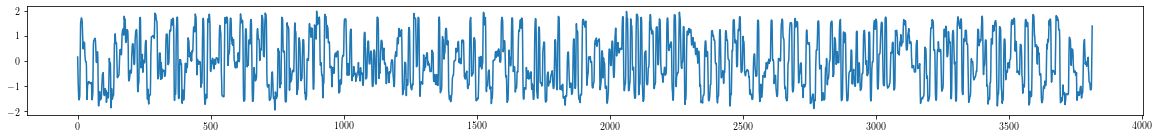

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))

ax.plot(y)

In [9]:
train_frac = 0.9
n_train = int(Y.shape[0] * train_frac)

In [10]:
X_train = X[:n_train]
X_test = X[n_train:]
Z_train = Y[:n_train]
Z_test = Y[n_train:]

In [11]:
A = np.identity(4)
A[0, 2] = dt
A[1, 3] = dt

In [12]:
ols = LinearRegression(fit_intercept=False)
ols.fit(X_train[:-1, 2:4], X_train[1:, 2:4])
A[2:4, 2:4] = ols.coef_

In [13]:
W = np.zeros(A.shape)
W_full = np.dot((X_train[1:] - np.dot(X_train[:-1], A)).T, X_train[1:] - np.dot(X_train[:-1], A)) / (n_train - 1)
W[2:4, 2:4] = W_full[2:4, 2:4]

In [14]:
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train, Z_train)
C = ols.coef_
d = ols.intercept_
Q = np.dot((Z_train - ols.predict(X_train)).T, Z_train - ols.predict(X_train)) / n_train

In [15]:
ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 0])
print(ols.score(Z_test, X_test[:, 0]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 0])[0, 1])

ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 1])
print(ols.score(Z_test, X_test[:, 1]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 1])[0, 1])

0.1806404408996659
0.44347428746732614
0.22522071133193447
0.5095152936300446


In [16]:
kf = KalmanFilter(
    transition_matrices=A,
    observation_matrices=C,
    observation_offsets=d,
    transition_offsets=np.zeros(4),
    transition_covariance=W,
    observation_covariance=Q
)

In [17]:
means, _ = kf.filter(Z_test)

In [18]:
for idx in range(4):
    print(r2_score(X_test[:, idx], means[:, idx]))
    
print('---')

for idx in range(4):
    print(np.corrcoef(X_test[:, idx], means[:, idx])[0, 1])

0.5058244281902426
0.07516034651745573
0.4484183569749377
0.4321410131660346
---
0.7310654600062806
0.7014882275550482
0.6711940431623431
0.6801183826934516


In [35]:
for idx in range(4):
    print(r2_score(X_test[:, idx], means[:, idx]))
    
print('---')

for idx in range(4):
    print(np.corrcoef(X_test[:, idx], means[:, idx])[0, 1])

0.5706193353820819
0.4633433271195536
0.46085237082105424
0.509243296364986
---
0.7667011890528377
0.773524879268494
0.6869202396476253
0.7312487777505384


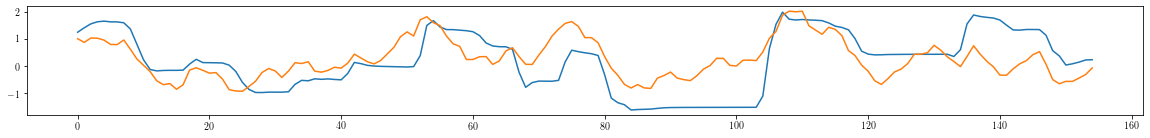

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))
plt.plot(X_test[500:, 0])
plt.plot(means[500:, 0])

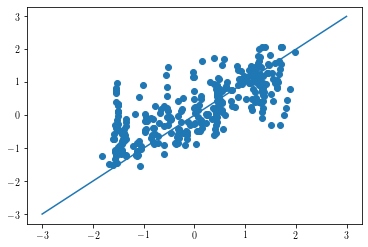

In [22]:
plt.scatter(X_test[:, 0], means[:, 0])
plt.plot([-3, 3], [-3, 3])

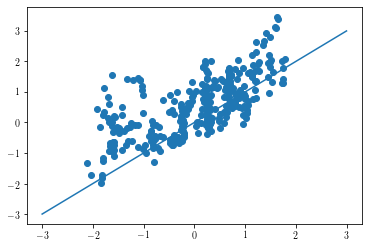

In [20]:
plt.scatter(X_test[:, 1], means[:, 1])
plt.plot([-3, 3], [-3, 3])